In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb

colour_pal = sns.color_palette()

# Load DataSet

In [17]:
df = pd.read_csv('DataSet/PJME_hourly.csv').set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


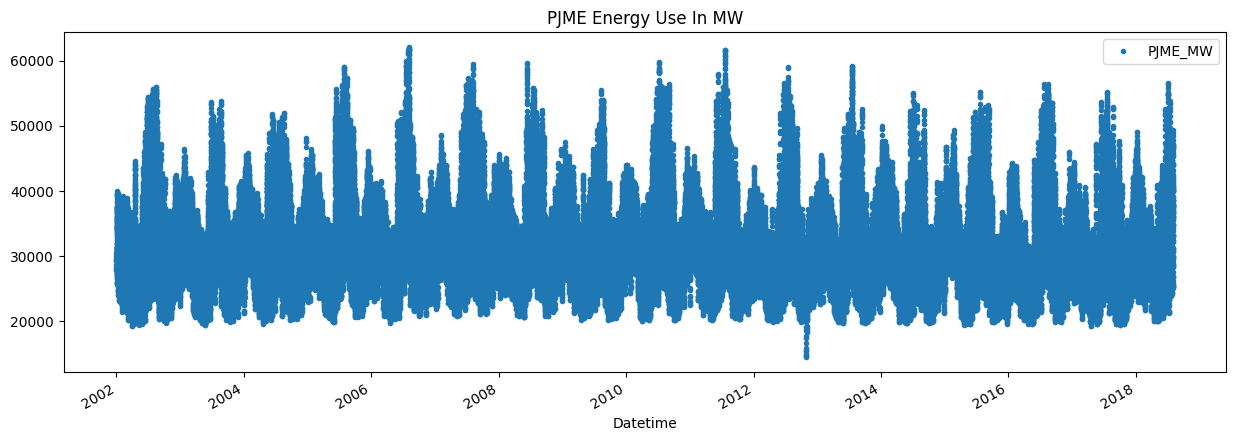

In [24]:
df.plot(style='.', 
        figsize=(15,5), 
        color=colour_pal[0], 
        title='PJME Energy Use In MW')
plt.show()

# Train/Test Split
- will split train and test on Jan 01 2015

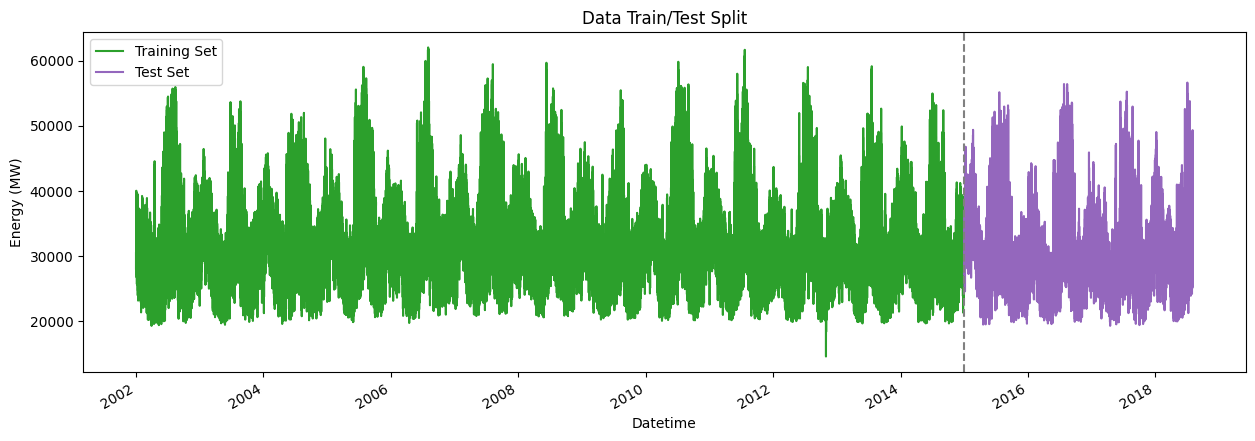

In [34]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

fig, ax =plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', color=colour_pal[2], title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set', color=colour_pal[4])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy (MW)')
plt.show()

Weekly Trends

<Axes: xlabel='Datetime'>

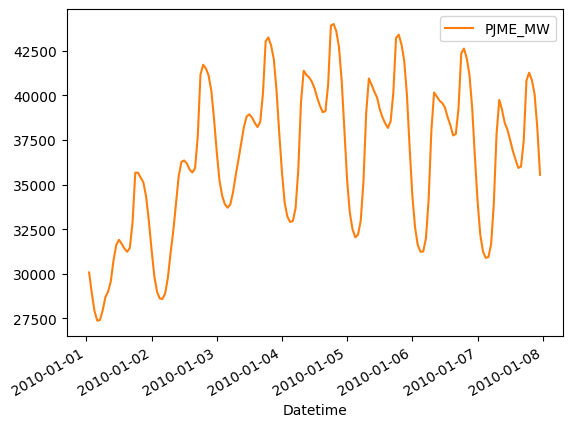

In [38]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(color=colour_pal[1])

# Feature Creation